# Entanglement renormalization

One can open this notebook in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/source/entanglement_renormalization.ipynb)

In the given tutorial, we show how the Riemannian optimization on the complex Stiefel manifold can be used to perform entanglement renormalization and find the ground state energy of a many-body spin system in the point of phase transition. First of all, let us import some libraries.

In [ ]:
import numpy as np
from scipy import integrate
import tensorflow as tf  # tf 2.x

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

# TensorNetwork library
try:
    import tensornetwork as tn
except ImportError:
    !pip install tensornetwork
    import tensornetwork as tn

import matplotlib.pyplot as plt
from tqdm import tqdm
tn.set_default_backend("tensorflow")

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## Renormalization layer

Here we define a renormalization layer by using TensorNetwork library. The function mera_layer takes unitary and isometric blocks and perform renormalization of a local Hamiltonian as it is shown on the tensor diagram below (if the diagram is not displayed here, please open the notebook in Google Colab).
![renorm_layer.png](images/renorm_layer.png)
For more information please see

Evenbly, G., & Vidal, G. (2009). Algorithms for entanglement renormalization. Physical Review B, 79(14), 144108.

Evenbly, G., & Vidal, G. (2014). Algorithms for entanglement renormalization: boundaries, impurities and interfaces. Journal of Statistical Physics, 157(4-5), 931-978.

In [ ]:
@tf.function
def mera_layer(H,
               U,
               U_conj,
               Z_left,
               Z_right,
               Z_left_conj,
               Z_right_conj):
    """
    Renormalizes local Hamiltonian.

    Args:
        H: complex valued tensor of shape (chi ** 2, chi ** 2),
            input two-side Hamiltonian (a local term).
        U: complex valued tensor of shape (chi ** 2, chi ** 2), disentangler
        U_conj: complex valued tensor of shape (chi ** 2, chi ** 2),
            conjugated disentangler.
        Z_left: complex valued tf tensor of shape (chi ** 3, new_chi),
            left isometry.
        Z_right: complex valued tf tensor of shape (chi ** 3, new_chi),
            right isometry.
        Z_left_conj: complex valued tf tensor of shape (chi ** 3, new_chi),
            left conjugated isometry.
        Z_right_conj: complex valued tf tensor of shape (chi ** 3, new_chi),
            right conjugated isometry.

    Returns: 
        complex valued tensor of shape (new_chi ** 2, new_chi ** 2),
        renormalized two side hamiltonian.
        
    Notes:
        chi is the dimension of an index. chi increases with the depth of mera, however,
        at some point, chi is cut to prevent exponential growth of indices
        dimensionality.
    """
    
    # index dimension before renormalization
    chi = tf.cast(tf.math.sqrt(tf.cast(U.shape[0], dtype=tf.float64)),
                  dtype=tf.int32)
    
    # index dimension after renormalization
    chi_new = Z_left.shape[-1]
    
    # tn nodes
    # here we build a tensor network that renormalizes a local Hamiltonian term
    # one can skip this part and use it as a black box

    # Hamiltonian
    h = tn.Node(tf.reshape(H, (chi, chi, chi, chi)))
    # disentangler
    u = tn.Node(tf.reshape(U, (chi, chi, chi, chi)))
    # conj. disentangler
    u_conj = tn.Node(tf.reshape(U_conj, (chi, chi, chi, chi)))
    # left isometry
    z_left = tn.Node(tf.reshape(Z_left, (chi, chi, chi, chi_new)))
    # right isometry
    z_right = tn.Node(tf.reshape(Z_right, (chi, chi, chi, chi_new)))
    # conj. left isometry
    z_left_conj = tn.Node(tf.reshape(Z_left_conj, (chi, chi, chi, chi_new)))
    # conj. right isometry
    z_right_conj = tn.Node(tf.reshape(Z_right_conj, (chi, chi, chi, chi_new)))
    
    # standard for all three diagrams environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # first diagram
    z_left[1]^h[2]
    z_left_conj[1]^h[0]
    u[0]^h[3]
    u_conj[0]^h[1]
    u[1]^u_conj[1]
    z_right[1]^z_right_conj[1]
    nodes = tn.reachable(h)
    renorm_first = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standard for all three diagrams environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # second diagram
    z_left[1]^z_left_conj[1]
    z_right[1]^z_right_conj[1]
    u[0]^h[2]
    u[1]^h[3]
    u_conj[0]^h[0]
    u_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_second = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standard for all three diagrams environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # third diagram
    z_left[1]^z_left_conj[1]
    u[0]^u_conj[0]
    u[1]^h[2]
    u_conj[1]^h[0]
    z_right[1]^h[3]
    z_right_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_third = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    # sum of all three diagrams
    h_renorm = (renorm_first.tensor +\
                renorm_second.tensor +\
                renorm_third.tensor) / 3

    return h_renorm


@tf.function
def z_gen(chi, new_chi):
    """Returns random isometry.

    Args:
        chi: int number, input chi.
        new_chi: int number, output chi.

    Returns:
        complex valued tensor of shape (chi ** 3, new_chi)."""
    
    # one can use the complex Stiefel manfiold to generate a random isometry
    m = qgo.manifolds.StiefelManifold()
    Z = m.random((chi ** 3, new_chi), dtype=tf.complex128)
    return Z


@tf.function
def u_gen(chi):
    """Returns the identity matrix of a given size (initial disentangler).

    Args:
        chi: int number.

    Returns:
        complex valued tensor of shape (chi ** 2, chi ** 2)."""
    
    U = tf.eye(chi ** 2, dtype=tf.complex128)
    return U

## TFI hamiltonian and MERA building blocks

Here we define the Transverse-field Ising model Hamiltonian and building blocks (disentanglers and isometries) of MERA network that will be optimized.

In [ ]:
#===========================================================================#
max_chi = 4 # max bond dim
num_of_layers = 5 # number of MERA layers (corresponds to 2*3^5 = 486 spins)
h_x = 1. # transvers field (h_x=1 is the critical field)
#===========================================================================#

# Pauli matrices
sigma = tf.constant([[[1j*0, 1 + 1j*0], [1 + 1j*0, 0*1j]],
                    [[0*1j, -1j], [1j, 0*1j]],
                    [[1 + 0*1j, 0*1j], [0*1j, -1 + 0*1j]]], dtype=tf.complex128)
    
# Hamiltonian (Transverse-field Ising model, local term)
h = -tf.einsum('ij,kl->ikjl', sigma[0], sigma[0]) +\
tf.einsum('ij,kl->ikjl', -h_x * sigma[2], tf.eye(2, dtype=tf.complex128))

# initial building blocks (disentanglers and isometries)

# first layer
U = u_gen(2)
Z = z_gen(2, max_chi)

# the rest layers
U_list = [u_gen(max_chi) for _ in range(num_of_layers - 1)]
Z_list = [z_gen(max_chi, max_chi) for _ in range(num_of_layers - 1)]

# all building blocks of mera packed in two lists
U_list = [U] + U_list
Z_list = [Z] + Z_list

# trial state in the renormalized space (low dimensional in comparison
# with the dimensionality of the initial problem)
psi = qgo.manifolds.real_to_complex(tf.random.normal((max_chi ** 2, 1, 2),
                                                     dtype=tf.float64))
psi, _ = tf.linalg.qr(psi)

# converting building blocks of mera to real representation (necessary for an optimizer)
U_list = [qgo.manifolds.complex_to_real(U_list[i]) for i in range(len(U_list))]
Z_list = [qgo.manifolds.complex_to_real(Z_list[i]) for i in range(len(Z_list))]
psi = qgo.manifolds.complex_to_real(psi)

## Optimization loop

MERA parametrizes quantum state $\Psi(\{U\}, \{Z\}, \psi)$ of a spin system, where $\{U\}$ is a set of disentanglers, $\{Z\}$ is a set of isometries, $\psi$ is a state in the renormalized space.
In order to find the ground state and its energy, we perform optimization of variational energy $$\langle\Psi(\{U\}, \{Z\}, \psi)|H_{\rm TFI}|\Psi(\{U\}, \{Z\}, \psi)\rangle\rightarrow \min_{\{U\}, \{Z\}, \psi\in {\rm Stiefel \ manifold}}$$

In [ ]:
#==================================#
iters = 3000 # number of iterations
lr_i = 0.6 # initial learning rate
lr_f = 0.1 # final learning rate
#==================================#

# learning rate decay coefficient
decay = (lr_f / lr_i) ** (1 / iters)

# optimizer
m = qgo.manifolds.StiefelManifold()  # Stiefel manifold
opt = qgo.optimizers.RAdam(m, lr_i)  # Riemannian Adam


E_list = [] # will be filled by energy per iteration

# Variables to be optimized
varU = [tf.Variable(U_re) for U_re in U_list] # disentanglers vars
varZ = [tf.Variable(Z_re) for Z_re in Z_list] # isometries vars
varpsi = tf.Variable(psi) # psi var
all_vars = varU + varZ + [varpsi] # all variables in one list

# optimization loop
for j in tqdm(range(iters)):

    # gradient calculation
    with tf.GradientTape() as tape:

        # convert real valued variables to complex valued tensors
        varU_c = [qgo.manifolds.real_to_complex(varU[i]) for i in range(len(varU))]
        varZ_c = [qgo.manifolds.real_to_complex(varZ[i]) for i in range(len(varZ))]
        varpsi_c = qgo.manifolds.real_to_complex(varpsi)

        # initial local Hamiltonian term
        h_renorm = h
        
        # renormalization of a local Hamiltonian term
        for i in range(len(varU)):
            h_renorm = mera_layer(h_renorm,
                                  varU_c[i],
                                  tf.math.conj(varU_c[i]),
                                  varZ_c[i],
                                  varZ_c[i],
                                  tf.math.conj(varZ_c[i]),
                                  tf.math.conj(varZ_c[i]))
            
        # renormalizad Hamiltonian (low dimensional)
        h_renorm = (h_renorm + tf.transpose(h_renorm, (1, 0, 3, 2))) / 2
        h_renorm = tf.reshape(h_renorm, (max_chi * max_chi, max_chi * max_chi))
        
        # energy
        E = tf.cast((tf.transpose(tf.math.conj(varpsi_c)) @ h_renorm @ varpsi_c),
                    dtype=tf.float64)[0, 0]
        
        # adding information for validation
        E_list.append(E)

    # gradients
    grad = tape.gradient(E, all_vars)
    
    # optimization step
    opt.apply_gradients(zip(grad, all_vars))
    
    # learning rate update
    opt._set_hyper("learning_rate", opt._get_hyper("learning_rate") * decay)

Plotting difference between the exact value of energy and value found by entanglement renormalization.

MERA energy: -1.2731158867108772
Exact energy: -1.2732417615356748


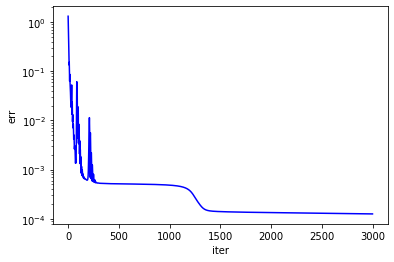

In [ ]:
# exact value of energy in the critical point
N = 2 * (3 ** num_of_layers) # number of spins (for 5 layers one has 486 spins)
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * N))) / N # exact energy

plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.plot(E_list - tf.convert_to_tensor(([E0_exact_fin] * len(E_list))), 'b')
print("MERA energy:", E_list[-1].numpy())
print("Exact energy:", E0_exact_fin)